# Results Exploration

In [1]:
import sys
sys.path.append('./../src/')

import os
import re
import ast
import utils
import ioutil

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from feature_selection import _feature_importance_permutation

from sklearn.metrics import roc_auc_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split

%matplotlib inline

/Users/severinlangberg/anaconda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def prep_selector_labels(labels):
    
    outputs = []
    for label in labels:
        splitted = label.split('_')
        
        if 'var' in splitted:
            outputs.append('Variance Threshold')
        if 'mutual' in splitted:
            for num, item in enumerate(splitted):
                splitted[num] = item.capitalize()
            outputs.append((' ').join(splitted))
        if 'relieff' in splitted:
            for num, item in enumerate(splitted):
                splitted[num] = item[:-1].capitalize() + item[-1].capitalize()
            outputs.append(('').join(splitted))
        if 'logregl1' in splitted:
            outputs.append('{}:\n{}'.format('Permutation Importance', 'Logistic Regression L1'))
        if 'logregl2' in splitted:
            outputs.append('{}:\n{}'.format('Permutation Importance', 'Logistic Regression L2'))
        if 'rf' in splitted:
            outputs.append('{}:\n{}'.format('Permutation Importance', 'Random Forest'))
            
    return outputs

In [3]:
def prep_feature_names(labels, image_type='squareroot'):
    
    outputs = []
    for label in labels:
        if image_type in label:
        
            if 'firstorder' in label:
                modality, _, kind, name = label.split('_')
                outputs.append('{} {}:\n{}'.format(
                    modality.upper(), kind.capitalize(), name)
                )
            else:
                modality, _, kind, name = label.split('_')
                outputs.append('{} {}:\n{}'.format(modality.upper(), kind.upper(), name))
        # Clinical variables.
        else:
            if 'hpv_1' in label:
                outputs.append('Recieved HPV')
            if 'hpv_2' in label:
                outputs.append('Missing HPV information')
            if 'peak' in label:
                outputs.append('SUV Peak')
            if 'mtv' in label:
                outputs.append(label.upper())
            if 't_class_3' in label:
                outputs.append('T-class 3')
            if 'stage' in label:
                outputs.append('Stage {}'.format(label.split('_')[1]))
            if 'icd10_C32' in label:
                outputs.append('ICD-10: C32')
            if 'cisplatin_6' in label:
                outputs.append('Cisplatin: 6')
            if 'original' in label:
                _, kind, name = label.split('_') 
                outputs.append('{}: {}'.format(kind.capitalize(), name))
            if 'cisplatin' in label:
                outputs.append('Cisplatin {}'.format(label.split('_')[1]))
                
    return outputs

In [4]:
X = pd.read_csv(
    #'./../../data/fallback/data_to_analysis/data.csv', index_col=0
    './../../data/clinical_experiment/data_to_analysis/clinical_vars.csv', index_col=0
)
y_pfs = pd.read_csv(
    './../../data/fallback/data_to_analysis/target_pfs.csv', index_col=0
)
y_lrc = pd.read_csv(
    './../../data/fallback/data_to_analysis/target_lrc.csv', index_col=0
)

In [5]:
X.shape

(198, 46)

## PFS

In [6]:
pfs_results_raw = pd.read_csv(
    './../../data/clinical_experiment/results/clin_results_dfs.csv', index_col=0
)
pfs_results_raw.head()

,experiment_id,model,selector,best_params,avg_test_score,avg_train_score,best_features,num_features
0,684,AdaBoostClassifier,logregl1_permut_imp,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.525827,0.525827,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,41
1,559,AdaBoostClassifier,logregl1_permut_imp,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.540146,0.540146,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,42
2,629,AdaBoostClassifier,logregl1_permut_imp,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.525670,0.525670,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,42
3,192,AdaBoostClassifier,logregl1_permut_imp,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.549044,0.549044,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,41
4,835,AdaBoostClassifier,logregl1_permut_imp,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.520001,0.520001,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,42


In [7]:
model_names = []

avg_pfs_results = np.zeros((6, 6), dtype=float)
std_pfs_results = np.zeros((6, 6), dtype=float)
for row_num, (model_name, model_grp) in enumerate(pfs_results_raw.groupby('model')):
    model_names.append(model_name)
    for col_num, (selector_name, selector_grp) in enumerate(model_grp.groupby('selector')):
        avg_pfs_results[row_num, col_num] = selector_grp['avg_test_score'].mean()
        std_pfs_results[row_num, col_num] = selector_grp['avg_test_score'].std()

In [8]:
selector_names = prep_selector_labels(pfs_results_raw.selector.unique())

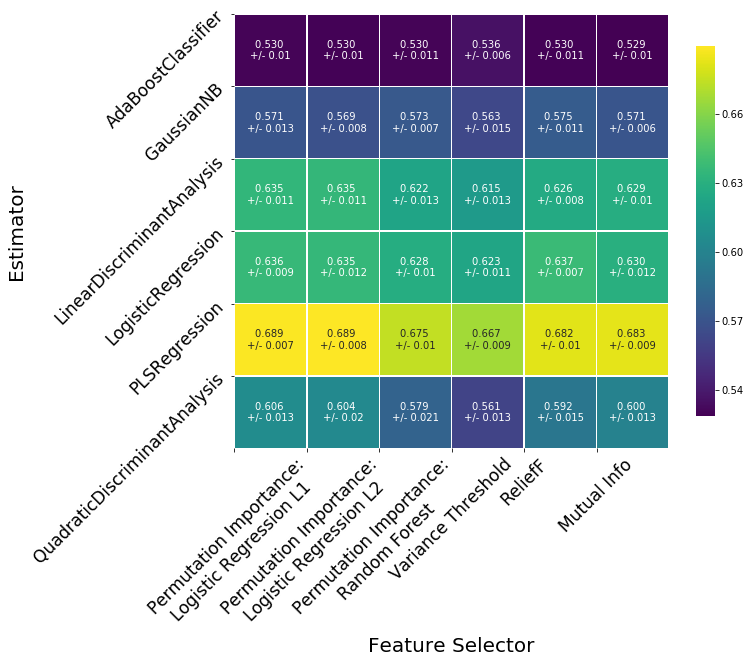

In [9]:
plt.figure(figsize=(11, 11))
axis = sns.heatmap(
    avg_pfs_results, 
    vmin=np.nanmin(avg_pfs_results), vmax=np.nanmax(avg_pfs_results),
    cmap=plt.cm.viridis, robust=True,
    annot=True, fmt = '.3f', square=1, linewidth=.5, cbar=True,
    cbar_kws={'shrink': 0.6},  
)
plt.ylabel('Estimator', fontsize=20)
plt.xlabel('Feature Selector', fontsize=20)
plt.xticks(
    range(np.size(selector_names)), selector_names, 
    rotation='45', fontsize=17, x='right', va='top', 
)
plt.yticks(
    range(np.size(model_names)), model_names, 
    rotation='45', fontsize=17, y=-0.5
)
for num, value in enumerate(axis.texts): 
    value.set_text('{} \n+/- {}'.format(
        value.get_text(), 
        np.round(std_pfs_results.ravel()[num], decimals=3),
        fontsize=16
    )
)
plt.tight_layout()   
plt.savefig(
    './../../data/clinical_experiment/figures/dfs_clinical_matrix.png', 
    transparent=True, dpi=400
)

## LRC

In [10]:
lrc_results_raw = pd.read_csv(
    './../../data/clinical_experiment/results/clin_results_lrc.csv', index_col=0
)
lrc_results_raw.head()

,avg_test_score,avg_train_score,best_features,best_params,experiment_id,model,num_features,selector
0,0.512270,0.512270,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",684,AdaBoostClassifier,41,logregl1_permut_imp
1,0.518780,0.518780,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",559,AdaBoostClassifier,42,logregl1_permut_imp
2,0.513156,0.513156,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",629,AdaBoostClassifier,42,logregl1_permut_imp
3,0.505250,0.505250,[ 0 1 2 3 4 6 7 8 9 10 11 12 13 14 15 ...,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",192,AdaBoostClassifier,40,logregl1_permut_imp
4,0.509569,0.509569,[ 0 1 2 3 4 6 7 8 9 10 11 12 13 14 15 ...,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",835,AdaBoostClassifier,41,logregl1_permut_imp


In [11]:
model_names = []

avg_lrc_results = np.zeros((6, 6), dtype=float)
std_lrc_results = np.zeros((6, 6), dtype=float)
for row_num, (model_name, model_grp) in enumerate(lrc_results_raw.groupby('model')):
    model_names.append(model_name)
    for col_num, (selector_name, selector_grp) in enumerate(model_grp.groupby('selector')):
        avg_lrc_results[row_num, col_num] = selector_grp['avg_test_score'].mean()
        std_lrc_results[row_num, col_num] = selector_grp['avg_test_score'].std()

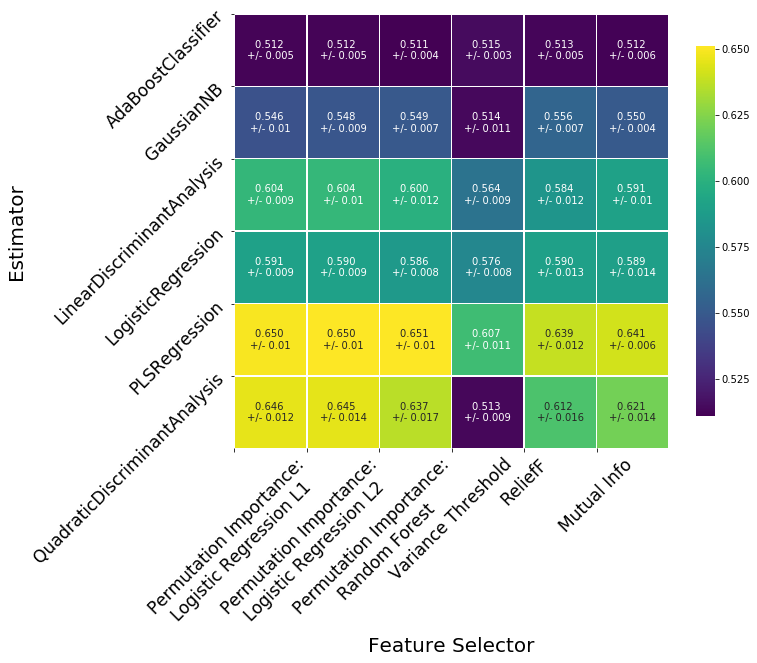

In [12]:
plt.figure(figsize=(11, 11))
axis = sns.heatmap(
    avg_lrc_results, 
    vmin=np.nanmin(avg_lrc_results), vmax=np.nanmax(avg_lrc_results),
    cmap=plt.cm.viridis, robust=True,
    annot=True, fmt = '.3f', square=1, linewidth=.5, cbar=True,
    cbar_kws={'shrink': 0.6},  
)
plt.ylabel('Estimator', fontsize=20)
plt.xlabel('Feature Selector', fontsize=20)
plt.xticks(
    range(np.size(selector_names)), selector_names, 
    rotation='45', fontsize=17, x='right', va='top', 
)
plt.yticks(
    range(np.size(model_names)), model_names, 
    rotation='45', fontsize=17, y=-0.5
)
for num, value in enumerate(axis.texts): 
    value.set_text('{} \n+/- {}'.format(
        value.get_text(), 
        np.round(std_lrc_results.ravel()[num], decimals=3),
        fontsize=16
    )
)
plt.tight_layout()   
plt.savefig(
    './../../data/clinical_experiment/figures/lrr_clinical_matrix.png',  
    transparent=True, dpi=400
)

## Feature analysis

In [13]:
def feature_consensus(df, num_feats=None):
    
    features = []
    votes = np.zeros(num_feats, dtype=int)
    for (model_name, model_data) in df.groupby('model'):
        if 'PLS' in model_name:
            for (sel_name, model_sel_data) in model_data.groupby('selector'):
                if 'logregl1' in sel_name:
                    for listing in model_sel_data['best_features'].values:
                        feature_set = [int(elem) for elem in re.findall(r'\d+', listing)]
                        features.append(feature_set)
                        votes[feature_set] += 1        

    return features, votes

In [14]:
pfs_features, pfs_votes = feature_consensus(pfs_results_raw, num_feats=X.columns.size)
lrc_features, lrc_votes = feature_consensus(lrc_results_raw, num_feats=X.columns.size)

In [15]:
pfs_votes[pfs_votes != 10] = 0
pfs_votes[pfs_votes == 10] = 1

In [16]:
lrc_votes[lrc_votes != 10] = 0
lrc_votes[lrc_votes == 10] = 1

In [17]:
sum(pfs_votes == 1), sum(lrc_votes == 1)

(39, 39)

In [18]:
np.size(pfs_votes), np.size(lrc_votes)

(46, 46)

In [24]:
model = PLSRegression(n_components=30, max_iter=500, scale=True, tol=0.001)

split = 160

X_pfs = X.loc[:, X.columns[pfs_votes == 1]]
_X, _y = X_pfs.values, np.squeeze(y_pfs.values)

X_train, y_train, = _X[:split, :], _y[:split]
X_test, y_test = _X[split:, :], _y[split:]

model.fit(X_train, y_train)

_, all_imps = _feature_importance_permutation(
    X_test, y_test, model,
    score_func=roc_auc_score, num_rounds=10, seed=0
)

In [25]:
# Output imp: ncols x nrouns
np.mean(all_imps, axis=1).shape

(39,)

In [26]:
def importance_ranking(X, y, model, seeds=10):
    
    importances = []
    for seed in range(seeds):
        
        sampler = utils.BootstrapOutOfBag(n_splits=50, random_state=seed)
        for train_idx, test_idx in sampler.split(X, y):
            
            X_train, X_test = X[train_idx, :], X[test_idx, :]
            y_train, y_test = y[train_idx], y[test_idx]
            X_train_std, X_test_std = utils.train_test_z_scores(X_train, X_test)
            
            model.fit(X_train_std, y_train)
            
            _, all_imps = _feature_importance_permutation(
                X_test_std, y_test, model, score_func=roc_auc_score, 
                num_rounds=10, seed=seed
            )
        importances.append(np.mean(all_imps, axis=1))
        
    return np.mean(importances, axis=0), np.std(importances, axis=0)

In [27]:
X_pfs = X.loc[:, X.columns[pfs_votes == 1]]
X_lrc = X.loc[:, X.columns[lrc_votes == 1]]

In [29]:
pfs_model = PLSRegression(n_components=30, max_iter=500, scale=True, tol=0.001)
avg_pfs_importances, std_pfs_importances = importance_ranking(
    X_pfs.values, np.squeeze(y_pfs.values), pfs_model
)

In [31]:
lrc_model = PLSRegression(n_components=30, max_iter=500, scale=True, tol=0.001)
avg_lrc_importances, std_lrc_importances = importance_ranking(
    X_lrc.values, np.squeeze(y_lrc.values), lrc_model
)

In [32]:
# Select top n features.
n_top = 5
pfs_top_idx = avg_pfs_importances.argsort()[-n_top:][::-1]
lrc_top_idx = avg_lrc_importances.argsort()[-n_top:][::-1]

pfs_avg_top = avg_pfs_importances[pfs_top_idx]
lrc_avg_top = avg_lrc_importances[lrc_top_idx]

pfs_std_top = std_pfs_importances[pfs_top_idx]
lrc_std_top = std_lrc_importances[lrc_top_idx]

In [47]:
X_pfs.columns[pfs_top_idx]

Index(['stage_2', 'hpv_1', 'stage_3', 'icd10_C02', 'ecog_1'], dtype='object')

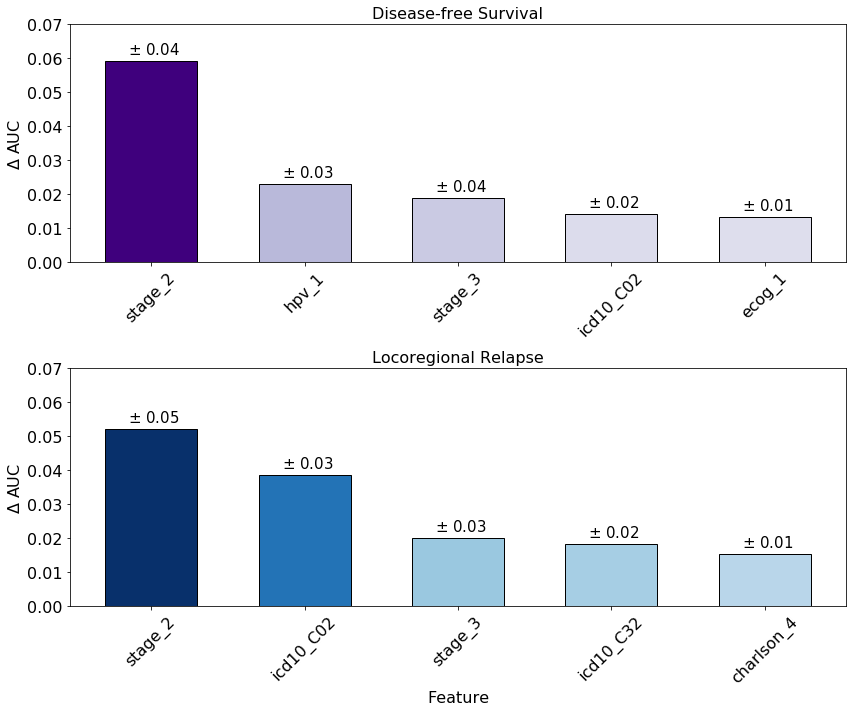

In [50]:
from matplotlib.cm import ScalarMappable


FONTSIZE = 16

# Cmap setup.
cmap1 = plt.cm.get_cmap('Purples'); cmap2 = plt.cm.get_cmap('Blues')
pfs_colors = [bar / max(pfs_avg_top) for bar in pfs_avg_top]
lrc_colors = [bar / max(lrc_avg_top) for bar in lrc_avg_top]

# Compare top features.
fig, axes = plt.subplots(nrows=2, figsize=(12, 10))

axes[0].bar(
    x=range(n_top), height=pfs_avg_top, width=0.6, label='DFS',
    #tick_label=prep_feature_names(X_pfs.columns[pfs_top_idx]),
    tick_label=X_pfs.columns[pfs_top_idx],
    color=cmap1(pfs_colors), edgecolor='k'
)
axes[0].set_title('Disease-free Survival', fontsize=FONTSIZE)
axes[1].bar(
    x=range(n_top), height=lrc_avg_top, width=0.6, label='LRC',
    #tick_label=prep_feature_names(X_lrc.columns[lrc_top_idx]),
    tick_label=X_lrc.columns[lrc_top_idx],
    color=cmap2(lrc_colors), edgecolor='k'
)
axes[1].set_title('Locoregional Relapse', fontsize=FONTSIZE)
for axis in axes.ravel():
    axis.yaxis.set_tick_params(labelsize=FONTSIZE)
    axis.xaxis.set_tick_params(labelsize=FONTSIZE, rotation=45)
    axis.set_ylabel(r'$\Delta$ AUC', fontsize=FONTSIZE)
    axis.set_ylim([0, 0.07])

# Set annotations.
for num, patch in enumerate(axes[0].patches):
    # get_width pulls left or right; get_y pushes up or down
    axes[0].text(
        patch.get_x() + 0.15, patch.get_height() + 2e-3, 
        r'$\pm$ {}'.format(np.round(pfs_std_top[num], decimals=2)),
        fontsize=15, color='k'
    )

for num, patch in enumerate(axes[1].patches):
    # get_width pulls left or right; get_y pushes up or down
    axes[1].text(
        patch.get_x() + 0.15, patch.get_height() + 2e-3, 
        r'$\pm$ {}'.format(np.round(lrc_std_top[num], decimals=2)),
        fontsize=15, color='k' #'dimgrey'
    )
    


#axes[0].axhline(y=0.05, c='m', linestyle='--', dashes=(5, 10))
#axes[0].text(3.7, 0.01, 'y={}'.format(0.05))
#axes[1].axhline(y=0.05, c='m', linestyle='--', dashes=(5, 10))
#axes[1].text(-1, 1, 'y={}'.format(0.05))
    
plt.xlabel('Feature', fontsize=FONTSIZE)
plt.tight_layout()
plt.savefig('./../../data/fallback/figures/feature_rankings.png')

In [ ]:
pfs_inid = pfs_avg_top > pfs_std_top
np.array(prep_feature_names(X_pfs.columns[pfs_top_idx]))[pfs_inid]

In [ ]:
lrc_inid = lrc_avg_top > lrc_std_top
np.array(prep_feature_names(X_lrc.columns[lrc_top_idx]))[lrc_inid]

In [57]:
np.linspace(0.0, np.max(pfs_avg_top), 5,)

array([0.        , 0.01251864, 0.02503729, 0.03755593, 0.05007457])

In [53]:
pfs_avg_top

array([0.05007457, 0.04284814, 0.04274496, 0.03444852, 0.02342406])

In [18]:
alise_data = pd.read_excel('./../../alise_material/X_endelig_squareroot.xlsx', index_col=0)
alise_data.head()

,Toklasser,T_ny,Naxogin_dager,Cisplatin,Alder,Kjoenn,ICD10 kort,HPV,Pakkeaar,N,...,CT_squareroot_glszm_SmallAreaHighGrayLevelEmphasis,CT_squareroot_glszm_SmallAreaLowGrayLevelEmphasis,CT_squareroot_glszm_ZoneEntropy,CT_squareroot_glszm_ZonePercentage,CT_squareroot_glszm_ZoneVariance,CT_squareroot_ngtdm_Busyness,CT_squareroot_ngtdm_Coarseness,CT_squareroot_ngtdm_Complexity,CT_squareroot_ngtdm_Contrast,CT_squareroot_ngtdm_Strength
pasientID,,,,,,,,,,,,,,,,,,,,,
2,0,2,39,6,60.832877,0,1,2,0.000000,2,...,81.132145,0.008285,5.702739,0.018143,6.730474e+05,1.639106,0.000943,0.002624,3.168692e-08,0.853535
4,0,2,33,5,49.906849,1,1,2,4.786027,2,...,94.195115,0.007764,5.747650,0.026498,7.788270e+04,1.205572,0.001341,0.011134,6.567805e-07,0.707846
5,0,2,42,0,54.238356,1,1,0,0.000000,0,...,245.525215,0.006063,6.176937,0.020846,2.805490e+05,0.916924,0.000831,0.011491,1.394817e-07,1.338367
8,0,3,0,3,54.687671,0,1,2,18.343836,2,...,378.108044,0.002130,6.337482,0.018759,1.701674e+06,3.581822,0.000136,0.003319,2.288915e-08,0.638575
10,0,3,35,6,61.728767,0,1,2,0.000000,2,...,96.266692,0.011272,5.444106,0.028189,2.734023e+05,1.070095,0.001370,0.004991,1.197178e-07,1.253376


In [20]:
severin_data = pd.read_csv('./../../data/fallback/data_to_analysis/data.csv', index_col=0)
severin_data.head()

,age,year_smoking,days_naxogin,sex_M,icd10_C02,icd10_C03,icd10_C04,icd10_C05,icd10_C06,icd10_C09,...,ct_squareroot_glszm_ZoneEntropy,ct_squareroot_glszm_LargeAreaLowGrayLevelEmphasis,ct_squareroot_glszm_LargeAreaHighGrayLevelEmphasis,ct_squareroot_gldm_DependenceVariance,ct_squareroot_gldm_SmallDependenceHighGrayLevelEmphasis,ct_squareroot_ngtdm_Busyness,ct_squareroot_ngtdm_Strength,original_shape_Sphericity,original_shape_Elongation,original_shape_Flatness
ID,,,,,,,,,,,,,,,,,,,,,
2,60.832877,0.000000,39.0,1,0,0,0,0,0,1,...,6.902180,10.356601,2.400518e+08,25.059554,259.236529,0.163992,9.878748,0.661532,0.738882,0.723925
4,49.906849,4.786027,33.0,0,0,0,0,0,0,1,...,7.550984,0.214412,7.862366e+06,14.047097,898.009733,0.055962,11.937063,0.701721,0.796900,0.629917
5,54.238356,0.000000,42.0,0,0,0,0,0,0,1,...,7.721609,0.474081,3.840831e+07,21.546148,1099.996994,0.068100,12.562528,0.762365,0.600926,0.535140
8,54.687671,18.343836,0.0,1,0,0,0,0,0,0,...,7.278456,9.644831,3.206302e+09,38.048988,1136.266848,0.183863,18.997664,0.520001,0.784571,0.414247
10,61.728767,0.000000,35.0,1,0,0,0,0,0,0,...,6.687053,5.647078,1.439659e+08,34.140019,321.160762,0.125444,14.538118,0.643822,0.690320,0.539743


In [37]:
alise_data.filter(regex='PET').head()

,PET_squareroot_firstorder_10Percentile,PET_squareroot_firstorder_90Percentile,PET_squareroot_firstorder_Energy,PET_squareroot_firstorder_Entropy,PET_squareroot_firstorder_InterquartileRange,PET_squareroot_firstorder_Kurtosis,PET_squareroot_firstorder_Maximum,PET_squareroot_firstorder_MeanAbsoluteDeviation,PET_squareroot_firstorder_Mean,PET_squareroot_firstorder_Median,...,PET_squareroot_glszm_SmallAreaHighGrayLevelEmphasis,PET_squareroot_glszm_SmallAreaLowGrayLevelEmphasis,PET_squareroot_glszm_ZoneEntropy,PET_squareroot_glszm_ZonePercentage,PET_squareroot_glszm_ZoneVariance,PET_squareroot_ngtdm_Busyness,PET_squareroot_ngtdm_Coarseness,PET_squareroot_ngtdm_Complexity,PET_squareroot_ngtdm_Contrast,PET_squareroot_ngtdm_Strength
pasientID,,,,,,,,,,,,,,,,,,,,,
2,4.898979,10.954451,1105740.0,2.757454,3.797959,1.771539,12,2.012257,7.693829,7.745967,...,11.723056,0.125058,4.037401,0.001108,1.743055e+06,22.675469,0.001188,0.000627,2.522027e-06,0.052419
4,4.242641,7.937254,322110.0,2.281771,2.465563,2.131442,9,1.374523,5.552941,5.196152,...,0.391432,0.078248,3.700440,0.001346,1.170411e+06,24.099608,0.002697,0.000377,2.116379e-06,0.048275
5,4.000000,7.483315,520408.0,2.057575,2.324555,2.096772,8,1.142357,5.503950,5.656854,...,2.446463,0.229788,3.467720,0.000863,3.669076e+06,38.202373,0.001313,0.000195,1.459002e-06,0.020769
8,2.645751,5.916080,1326472.0,2.073673,1.549845,2.168352,7,0.895429,4.244846,4.582576,...,0.996146,0.130250,4.328600,0.000389,3.758486e+07,185.793562,0.000368,0.000035,1.887611e-07,0.005377
10,3.162278,4.472136,131890.0,0.922301,0.710706,2.793459,5,0.496768,3.452972,3.162278,...,0.263595,0.259428,3.499228,0.001582,4.039811e+06,35.190792,0.002831,0.000048,2.439249e-07,0.016262


In [35]:
severin_data.filter(regex='pet').head()

,pet_squareroot_firstorder_Minimum,pet_squareroot_firstorder_10Percentile,pet_squareroot_firstorder_Skewness,pet_squareroot_firstorder_Kurtosis,pet_squareroot_glcm_DifferenceEntropy,pet_squareroot_glrlm_ShortRunEmphasis,pet_squareroot_glrlm_LongRunEmphasis,pet_squareroot_glrlm_RunLengthNonUniformityNormalized,pet_squareroot_glszm_SmallAreaEmphasis,pet_squareroot_glszm_LargeAreaEmphasis,pet_squareroot_glszm_GrayLevelNonUniformity,pet_squareroot_glszm_ZoneVariance
ID,,,,,,,,,,,,
2,5.458577,8.725699,0.077688,1.719469,-3.203427e-16,0.107654,206.050600,0.059856,3.403118e-09,2.938482e+08,1.0,0.0
4,5.170671,6.634047,0.527697,1.967183,-3.203427e-16,0.104283,142.182120,0.062139,1.071410e-08,9.333492e+07,1.0,0.0
5,4.412679,6.547837,-0.117445,1.948504,-3.203427e-16,0.078583,223.626113,0.052613,3.803817e-09,2.628938e+08,1.0,0.0
8,3.487809,5.364761,0.201268,2.035836,-3.203427e-16,0.101930,334.396683,0.044885,2.079012e-10,4.809977e+09,1.0,0.0
10,4.072120,6.074375,0.099873,2.313114,-3.203427e-16,0.121182,134.870748,0.067437,8.654936e-09,1.155410e+08,1.0,0.0
